# Метрики графа: статьи (Article)

Ноутбук для наглядного анализа метрик **только по статьям** (узлы = статьи энциклопедии).  
Связи с авторами, публикациями и формулами учитываются как рёбра графа; **входящие ссылки между статьями** в онтологии идут на **Term**, а не на Article — это учтено в расчётах.

**Два способа получения данных:**
1. **Python + rdflib**: загрузка TTL-файлов из папки `graph/`.
2. **SPARQL**: запросы к GraphDB (при необходимости — выполнение из Python через `SPARQLWrapper`).

## 1. Загрузка данных

Подгружаем граф из TTL (локально) и при необходимости подключаемся к GraphDB для SPARQL.

In [ ]:
import sys
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS

# Локальный модуль загрузки
sys.path.insert(0, str(Path.cwd()))
from graph_loader import load_graph_from_ttl, DEFAULT_GRAPH_DIR, SG, FME, ME

# Для метрик центральности
import networkx as nx

# Загрузка графа из TTL
g = load_graph_from_ttl(DEFAULT_GRAPH_DIR)
print(f"Загружено триплов: {len(g)}")

Загружено триплов: 480055


### Собираем только статьи и объектные свойства для статей

Узлы — все объекты типа `sg:Article`. Рёбра считаем по объектным свойствам (без datatype).  
**Важно:** входящие ссылки на статью со стороны других статей идут в онтологии в **Term** (предикат `sg:hasRelation`), поэтому входящая степень статьи учитывает и «ссылки на термин» этой статьи.

In [ ]:
# Объектные свойства, исходящие из Article (для исходящей степени)
ARTICLE_OUT_PREDICATES = {
    # str(SG.hasAuthor),
    # str(SG.hasTerm),
    # str(SG.hasThesaurus),
    # str(SG.refersTo),
    # str(SG.hasFormula),
    str(SG.hasRelation),
}

# Предикаты, где Article — объект (входящая степень)
# hasArticle (Person -> Article), referredIn (Publication -> Article), usedIn (Formula -> Article)
ARTICLE_IN_PREDICATES = {
    # str(SG.hasArticle),   # Person hasArticle Article
    # str(SG.referredIn),   # Publication referredIn Article
    # str(SG.usedIn),       # Formula usedIn Article
}

# hasRelation: субъект Article, объект Term — входящие к статье считаем по Term
# (сколько раз какой-то Article ссылается на Term этой статьи)

In [ ]:
# Все статьи
articles = list(g.subjects(RDF.type, SG.Article))
article_uri_to_label = {}
for a in articles:
    label = g.value(a, RDFS.label, None)
    if label is not None:
        article_uri_to_label[str(a)] = str(label)
    else:
        article_uri_to_label[str(a)] = str(a)

# Article -> её Term (по hasTerm; у статьи ровно один Term в нашей модели)
article_to_term = {}
for a, _, t in g.triples((None, SG.hasTerm, None)):
    if (a, RDF.type, SG.Article) in g:
        article_to_term[str(a)] = str(t)

# Term -> список статей (одно название может быть у нескольких статей)
term_to_articles = defaultdict(list)
for a, _, t in g.triples((None, SG.hasTerm, None)):
    if (a, RDF.type, SG.Article) in g:
        term_to_articles[str(t)].append(str(a))

print(f"Число статей (узлов): {len(articles)}")
print(f"Статей с термином: {len(article_to_term)}")

Число статей (узлов): 9758
Статей с термином: 9758


In [ ]:
# Исходящая степень: (article, p, o) для p in ARTICLE_OUT_PREDICATES
out_degree = defaultdict(int)
for a in articles:
    sa = str(a)
    for p, o in g.predicate_objects(a):
        if str(p) in ARTICLE_OUT_PREDICATES:
            out_degree[sa] += 1

# Входящая степень: (s, p, article) для p in ARTICLE_IN_PREDICATES
# + входящие по Term: (other_article, hasRelation, term_this_article)
in_degree = defaultdict(int)
for s, p, o in g:
    if str(p) in ARTICLE_IN_PREDICATES and (o, RDF.type, SG.Article) in g:
        in_degree[str(o)] += 1

# Входящие на Term этой статьи (ссылки других статей на термин = входящие к статье)
for s, p, o in g.triples((None, SG.hasRelation, None)):
    if (s, RDF.type, SG.Article) in g:
        for art in term_to_articles.get(str(o), []):
            in_degree[art] += 1

# Общая степень = in + out
total_degree = {a: in_degree.get(a, 0) + out_degree.get(a, 0) for a in article_uri_to_label}

## 2. Общие метрики

- **Общее количество узлов** (статей)  
- **Общее количество связей**: считаем по объектным свойствам, инцидентным статьям (каждое ребро один раз — по исходящим из статей).

In [5]:
n_nodes = len(articles)
n_edges = sum(out_degree.values())  # каждое ребро от статьи учтено ровно раз
print("Общие метрики (статьи)")
print("  Узлов (статей):", n_nodes)
print("  Связей (рёбер):", n_edges)

Общие метрики (статьи)
  Узлов (статей): 9758
  Связей (рёбер): 57568


### Эквивалент через SPARQL (для GraphDB)

Ниже — те же показатели через SPARQL. Раскомментируйте и задайте `endpoint`, если используете GraphDB.

In [6]:
# SPARQL: количество статей и количество исходящих рёбер от статей
SPARQL_COUNTS = """
PREFIX sg: <https://scilib.ai/ontology/semantic-graph/>
SELECT (COUNT(DISTINCT ?article) AS ?nodes) (COUNT(*) AS ?edges)
WHERE {
  ?article a sg:Article .
  ?article ?p ?o .
  FILTER (?p IN (sg:hasAuthor, sg:hasTerm, sg:hasThesaurus, sg:refersTo, sg:hasFormula, sg:hasRelation))
}
"""
# from graph_loader import run_sparql
# rows = run_sparql(SPARQL_COUNTS, endpoint="http://localhost:7200/repositories/your_repo")
# if rows: print("Узлов:", rows[0].get("nodes"), "Связей:", rows[0].get("edges"))
print("SPARQL-запрос для подсчёта сохранён в переменной SPARQL_COUNTS")

SPARQL-запрос для подсчёта сохранён в переменной SPARQL_COUNTS


## 3. Распределение узлов по тезаурусам

Статьи связаны с тезаурусом через `sg:hasThesaurus` (значения `fme:` или `me:`).

In [6]:
thesaurus_count = defaultdict(int)
for a, _, th in g.triples((None, SG.hasThesaurus, None)):
    if (a, RDF.type, SG.Article) in g:
        uri = str(th)
        if "fme" in uri:
            thesaurus_count["FME (Энциклопедия мат. физики)"] += 1
        elif "me" in uri:
            thesaurus_count["ME (Математическая энциклопедия)"] += 1
        else:
            thesaurus_count[uri] += 1

df_thesaurus = pd.DataFrame([
    {"Тезаурус": k, "Количество статей": v} for k, v in sorted(thesaurus_count.items())
])
df_thesaurus

,Тезаурус,Количество статей
0,FME (Энциклопедия мат. физики),3586
1,ME (Математическая энциклопедия),6172


## 4. Средняя степень узлов

In [7]:
avg_degree = sum(total_degree.values()) / n_nodes if n_nodes else 0
avg_in = sum(in_degree.values()) / n_nodes if n_nodes else 0
avg_out = sum(out_degree.values()) / n_nodes if n_nodes else 0
print("Средняя степень (общая):", round(avg_degree, 4))
print("Средняя входящая степень:", round(avg_in, 4))
print("Средняя исходящая степень:", round(avg_out, 4))

Средняя степень (общая): 12.7533
Средняя входящая степень: 6.8538
Средняя исходящая степень: 5.8996


## 5. Топ-10 узлов по степени (с названиями)

Во всех таблицах — **названия статей** (rdfs:label).  
**Напоминание:** входящие связи между статьями идут в Term; при расчёте входящей степени мы учитываем ссылки на термин данной статьи.

In [8]:
def top10_df(article_scores, title="Степень", number=10):
    items = sorted(article_scores.items(), key=lambda x: -x[1])[:number]
    return pd.DataFrame([
        {"Название статьи": article_uri_to_label.get(a, a), "URI": a, title: v}
        for a, v in items
    ])

print("Топ-10 по общей степени:")
display(top10_df(total_degree, "Общая степень", 30))

Топ-10 по общей степени:


,Название статьи,URI,Общая степень
0,ФУНКТОР,http://libmeta.ru/me/article/790_FUNKTO,1478
1,ТЕОРИЯ,http://libmeta.ru/me/article/381_TEORI,1425
2,МНОЖЕСТВО,http://libmeta.ru/me/article/733_MNOZhESTV,1207
3,ПРОСТРАНСТВО,http://libmeta.ru/me/article/748_PROSTRANSTV,1189
4,ПРОСТРАНСТВО,http://libmeta.ru/me/article/752_PROSTRANSTV,1189
5,ПЕРЕГО́РОДК,http://libmeta.ru/me/article/222_PEREGÓROD,886
6,ПРЕДСТАВЛЕНИЕ,http://libmeta.ru/me/article/3_PREDSTAVLENI,871
7,ПРОИЗВОДНАЯ,http://libmeta.ru/me/article/1045_PROIZVODNA,788
8,СИСТЕМА,http://libmeta.ru/me/article/350_SISTEM,771
9,ГРУПІІА,http://libmeta.ru/me/article/1207_GRUPІІ,730


In [10]:
print("Топ-10 по входящей степени (в т.ч. ссылки на Term статьи):")
display(top10_df(dict(in_degree), "Входящая степень"))

Топ-10 по входящей степени (в т.ч. ссылки на Term статьи):


,Название статьи,URI,Входящая степень
0,ФУНКТОР,http://libmeta.ru/me/article/790_FUNKTO,1463
1,ТЕОРИЯ,http://libmeta.ru/me/article/381_TEORI,1423
2,МНОЖЕСТВО,http://libmeta.ru/me/article/733_MNOZhESTV,1203
3,ПРОСТРАНСТВО,http://libmeta.ru/me/article/748_PROSTRANSTV,1182
4,ПРОСТРАНСТВО,http://libmeta.ru/me/article/752_PROSTRANSTV,1182
5,ПЕРЕГО́РОДК,http://libmeta.ru/me/article/222_PEREGÓROD,880
6,ПРЕДСТАВЛЕНИЕ,http://libmeta.ru/me/article/3_PREDSTAVLENI,853
7,ПРОИЗВОДНАЯ,http://libmeta.ru/me/article/1045_PROIZVODNA,784
8,СИСТЕМА,http://libmeta.ru/me/article/350_SISTEM,769
9,ГРУПІІА,http://libmeta.ru/me/article/1207_GRUPІІ,722


In [11]:
print("Топ-10 по исходящей степени:")
display(top10_df(dict(out_degree), "Исходящая степень"))

Топ-10 по исходящей степени:


,Название статьи,URI,Исходящая степень
0,ГОМЕОМОРФИЗМ,http://libmeta.ru/me/article/1116_GOMEOMORFIZ,75
1,АЛГЕБРА,http://libmeta.ru/me/article/94_ALGEBR,70
2,КОММУТАТИВНАЯ АЛГЕБРА,http://libmeta.ru/me/article/992_KOMMUTATIVNAJa,70
3,ГЙЫБЕРТОВО ПРОСТРАНСТВО,http://libmeta.ru/me/article/1046_GJYBERTOVO,69
4,МАТЕМАТИЧЕСКАЯ СТАТИСТИКА,http://libmeta.ru/me/article/590_MATEMATIChESKAJa,67
5,АЈГЕБРАИЧЕСКАЯ КРИВАЯ,http://libmeta.ru/me/article/109_AЈGEBRAIChESKAJa,63
6,труТОПОЛОГИЧЕСКАЯ ГРУППА,http://libmeta.ru/me/article/422_truTOPOLOGICh...,63
7,ПРЕДСТАВЛЕНИЕ ТОПОЛОГИЧЕСКОИ,http://libmeta.ru/me/article/619_PREDSTAVLENIE,62
8,ОРТОГОНАЛЬНАЯ ГРУППА,http://libmeta.ru/me/article/68_ORTOGONAL'NAJa,62
9,АСТРОФИЗИКИ МАТЕМАТИЧЕСКИЕ ЗАДАЧИ,http://libmeta.ru/me/article/313_ASTROFIZIKI,59


## 6. Изолированные узлы

Изолированный узел — статья с нулевой степенью (ни входящих, ни исходящих связей по учтённым объектным свойствам).

In [9]:
isolated = [a for a in article_uri_to_label if total_degree.get(a, 0) == 0]
n_isolated = len(isolated)
print(f"Количество изолированных узлов: {n_isolated} ({100 * n_isolated / n_nodes:.2f}%)")
if n_isolated > 0 and n_isolated <= 20:
    display(pd.DataFrame([{"Название": article_uri_to_label.get(a, a)} for a in isolated]))
elif n_isolated > 20:
    print("(Показаны первые 20)")
    display(pd.DataFrame([{"Название": article_uri_to_label.get(a, a)} for a in isolated[:20]]))

Количество изолированных узлов: 1584 (16.23%)
(Показаны первые 20)


,Название
0,ИНВАРИАНТНАЯ РЕГУЛЯРИЗАЦИЯ
1,ИНВАРИАНТНОЕ МНОГООБРАЗИЕ
2,ИНВАРИАНТНОЕ МНОЖЕСТВО
3,ИНВАРИАНТНЫЙ ЗАРЯД В КВАНТОВОЙ ТЕОРИИ ПОЛЯ
4,АНТИСИММЕТРИЧНОЕ ПРОСТРАНСТВО ФОКА
5,ИНВАРИАНТНЫЙ ТОР
6,ИНВЕРСИИ МЕТОД
7,"ИНЕРТНАЯ МАССА, ИНЕРЦИАЛЬНАЯ МАССА"
8,"ИНТЕГРАЛ ПРЕДСТАВЛЕНИЙ, ПРЯМОЙ ИНТЕГРАЛ ПРЕДСТ..."
9,ИНТЕГРАЛЬНАЯ КРИВАЯ


## 7. Плотность графа

Плотность ориентированного графа: $D = \\frac{|E|}{|V|(|V|-1)}$ (доля существующих дуг от максимально возможного числа).

In [10]:
max_edges = n_nodes * (n_nodes - 1) if n_nodes > 1 else 0
density = n_edges / max_edges if max_edges else 0.0
print(f"Плотность (ориентированный граф): {density:.6f}")
print(f"  Рёбер: {n_edges}, макс. возможных: {max_edges}")

Плотность (ориентированный граф): 0.000605
  Рёбер: 57568, макс. возможных: 95208806


## 8. Метрики центральности

Граф для центральности строится **только по связям статей между собой**: ребро A → B, если статья A ссылается на термин статьи B (`hasRelation` на Term). Остальные связи (авторы, публикации, формулы) в этом подграфе не учитываются.

In [11]:
# Орграф статей: ребро (a1, a2) если a1 hasRelation term и a2 hasTerm term
G_articles = nx.DiGraph()
article_set = set(str(a) for a in articles)
for a in articles:
    G_articles.add_node(str(a))

for s, _, term in g.triples((None, SG.hasRelation, None)):
    if (s, RDF.type, SG.Article) not in g:
        continue
    src = str(s)
    for tgt in term_to_articles.get(str(term), []):
        if tgt != src and tgt in article_set:
            G_articles.add_edge(src, tgt)

print(f"Узлов в графе связей статей: {G_articles.number_of_nodes()}")
print(f"Дуг (статья → статья): {G_articles.number_of_edges()}")

Узлов в графе связей статей: 9758
Дуг (статья → статья): 66518


### 8.1 Betweenness Centrality (центральность по посредничеству)

In [15]:
# Для графа без рёбер nx.betweenness_centrality всё равно вернёт словарь с нулями
betweenness = nx.betweenness_centrality(G_articles) if G_articles.number_of_edges() else {n: 0.0 for n in G_articles}
print("Топ-10 по центральности по посредничеству (Betweenness):")
display(top10_df(betweenness, "Betweenness"))

Топ-10 по центральности по посредничеству (Betweenness):


,Название статьи,URI,Betweenness
0,АЛГЕБРА,http://libmeta.ru/me/article/94_ALGEBR,0.011818
1,ФУНКТОР,http://libmeta.ru/me/article/790_FUNKTO,0.011395
2,ПРЕДСТАВЛЕНИЕ,http://libmeta.ru/me/article/3_PREDSTAVLENI,0.010701
3,ПОРЯДОК,http://libmeta.ru/me/article/531_PORJaDO,0.009569
4,ГОМЕОМОРФИЗМ,http://libmeta.ru/me/article/1116_GOMEOMORFIZ,0.007626
5,ПОЛУГРУППА,http://libmeta.ru/me/article/457_POLUGRUPP,0.005996
6,НЕРАВЕНСТВО,http://libmeta.ru/me/article/973_NERAVENSTV,0.005456
7,ЧИСЛО,http://libmeta.ru/me/article/1009_ChISL,0.004957
8,КОМПАКТНОСТЬ,http://libmeta.ru/me/article/1005_KOMPAKTNOST,0.004939
9,ПОЛI0С,http://libmeta.ru/me/article/501_POLI0,0.004858


### 8.2 Eigenvector Centrality (центральность по собственному вектору)

In [16]:
try:
    eigenvector = nx.eigenvector_centrality(G_articles, max_iter=500)
except (nx.PowerIterationFailedConvergence, nx.NetworkXError):
    eigenvector = {n: 0.0 for n in G_articles}
print("Топ-10 по центральности по собственному вектору (Eigenvector):")
display(top10_df(eigenvector, "Eigenvector"))

Топ-10 по центральности по собственному вектору (Eigenvector):


,Название статьи,URI,Eigenvector
0,МНОЖЕСТВО,http://libmeta.ru/me/article/733_MNOZhESTV,0.340007
1,ПРОСТРАНСТВО,http://libmeta.ru/me/article/748_PROSTRANSTV,0.313199
2,ПРОСТРАНСТВО,http://libmeta.ru/me/article/752_PROSTRANSTV,0.313199
3,ТЕОРИЯ,http://libmeta.ru/me/article/381_TEORI,0.279504
4,ФУНКТОР,http://libmeta.ru/me/article/790_FUNKTO,0.223286
5,СИСТЕМА,http://libmeta.ru/me/article/350_SISTEM,0.209984
6,МНОГООБРАЗИЙ,http://libmeta.ru/me/article/438_MNOGOOBRAZI,0.177082
7,ПЕРЕГО́РОДК,http://libmeta.ru/me/article/222_PEREGÓROD,0.152396
8,ПРОИЗВОДНАЯ,http://libmeta.ru/me/article/1045_PROIZVODNA,0.148069
9,КОМПАКТНОСТЬ,http://libmeta.ru/me/article/1005_KOMPAKTNOST,0.129261


### 8.3 PageRank

In [13]:
pagerank = nx.pagerank(G_articles)
print("Топ-10 по PageRank:")
display(top10_df(pagerank, "PageRank", 20))

Топ-10 по PageRank:


,Название статьи,URI,PageRank
0,МНОЖЕСТВО,http://libmeta.ru/me/article/733_MNOZhESTV,0.021868
1,СИСТЕМА,http://libmeta.ru/me/article/350_SISTEM,0.016727
2,ФУНКТОР,http://libmeta.ru/me/article/790_FUNKTO,0.016543
3,ТЕОРИЯ,http://libmeta.ru/me/article/381_TEORI,0.016528
4,ПРОСТРАНСТВО,http://libmeta.ru/me/article/748_PROSTRANSTV,0.016185
5,ПРОСТРАНСТВО,http://libmeta.ru/me/article/752_PROSTRANSTV,0.016185
6,ФОРМУЛА,http://libmeta.ru/me/article/741_FORMUL,0.010982
7,МНОГООБРАЗИЙ,http://libmeta.ru/me/article/438_MNOGOOBRAZI,0.010536
8,АКСИОМАТИЧЕСКИИ МЕТОД,http://libmeta.ru/me/article/90_AKSIOMATIChESKII,0.007457
9,ПРОИЗВОДНАЯ,http://libmeta.ru/me/article/1045_PROIZVODNA,0.007420


## 9. Топ-10 компонент связности

Для каждой компоненты слабой связности считаем все перечисленные выше метрики; вместо таблиц топ-10 узлов приводим **лишь первый узел** (лидер по соответствующей метрике). Дополнительно: **доля графа** (%), занимаемая компонентой, и **эффективный диаметр** компоненты (90-й перцентиль длин кратчайших путей).

In [18]:
def thesaurus_counts_for_nodes(g, nodes, article_uri_set):
    """По множеству URI статей вернуть счётчики FME / ME."""
    fme, me = 0, 0
    for a in nodes:
        if a not in article_uri_set:
            continue
        th = g.value(URIRef(a), SG.hasThesaurus, None)
        if th is None:
            continue
        uri = str(th)
        if "fme" in uri:
            fme += 1
        elif "me" in uri:
            me += 1
    return {"FME": fme, "ME": me}


def effective_diameter_90(G_sub, directed=True):
    """Эффективный диаметр: 90-й перцентиль длин кратчайших путей (по достижимым парам)."""
    if G_sub.number_of_nodes() <= 1 or G_sub.number_of_edges() == 0:
        return float("nan")
    try:
        H = G_sub.to_undirected() if directed else G_sub
        lengths = []
        for c in nx.connected_components(H):
            if len(c) < 2:
                continue
            S = H.subgraph(c)
            nodes = list(S.nodes())
            if len(nodes) > 400:
                import random
                random.seed(42)
                nodes_sample = random.sample(nodes, min(400, len(nodes)))
                for i, u in enumerate(nodes_sample):
                    for v in nodes_sample[i+1:]:
                        try:
                            lengths.append(nx.shortest_path_length(S, u, v))
                        except nx.NetworkXNoPath:
                            pass
            else:
                for src, lengths_dict in nx.all_pairs_shortest_path_length(S):
                    for tgt, L in lengths_dict.items():
                        if src != tgt and L > 0:
                            lengths.append(L)
        if not lengths:
            return float("nan")
        return float(np.percentile(lengths, 90))
    except Exception:
        return float("nan")


def component_metrics(comp_nodes, G_full, g, article_uri_to_label, in_degree, out_degree,
                      total_degree, thesaurus_count_fn, n_nodes_global):
    """Метрики одной компоненты (comp_nodes — множество URI). Центральности считаются по подграфу."""
    comp = set(comp_nodes)
    if not comp:
        return None
    sub = G_full.subgraph(comp)
    n = sub.number_of_nodes()
    m = sub.number_of_edges()
    art_set = set(article_uri_to_label.keys())

    th = thesaurus_count_fn(g, comp, art_set)
    fme, me = th.get("FME", 0), th.get("ME", 0)

    tot_deg = [total_degree.get(u, 0) for u in comp]
    in_d = [in_degree.get(u, 0) for u in comp]
    out_d = [out_degree.get(u, 0) for u in comp]
    avg_deg = sum(tot_deg) / n if n else 0
    avg_in = sum(in_d) / n if n else 0
    avg_out = sum(out_d) / n if n else 0

    isolated = sum(1 for d in tot_deg if d == 0)
    max_edges = n * (n - 1) if n > 1 else 0
    density = m / max_edges if max_edges else 0.0

    def top1(metric_dict, default=0):
        items = [(u, metric_dict.get(u, default)) for u in comp]
        if not items:
            return "", 0
        u, v = max(items, key=lambda x: x[1])
        return article_uri_to_label.get(u, u), v

    t1_tot_label, _ = top1(total_degree)
    t1_in_label, _ = top1(in_degree)
    t1_out_label, _ = top1(out_degree)

    try:
        bet_sub = nx.betweenness_centrality(sub) if m > 0 else {u: 0.0 for u in comp}
    except Exception:
        bet_sub = {u: 0.0 for u in comp}
    try:
        eig_sub = nx.eigenvector_centrality(sub, max_iter=500) if m > 0 else {u: 0.0 for u in comp}
    except Exception:
        eig_sub = {u: 0.0 for u in comp}
    try:
        pr_sub = nx.pagerank(sub) if m > 0 else {u: 1.0/n for u in comp}
    except Exception:
        pr_sub = {u: 0.0 for u in comp}

    t1_bet_label, _ = top1(bet_sub)
    t1_eig_label, _ = top1(eig_sub)
    t1_pr_label, _ = top1(pr_sub)

    pct = 100 * n / n_nodes_global if n_nodes_global else 0
    eff_d = effective_diameter_90(sub, directed=True)

    return {
        "Узлов": n, "Рёбер": m,
        "FME": fme, "ME": me,
        "Средняя степень": round(avg_deg, 4), "Сред. вх.": round(avg_in, 4), "Сред. исх.": round(avg_out, 4),
        "1-й по общей степени": t1_tot_label, "1-й по вх. степени": t1_in_label, "1-й по исх. степени": t1_out_label,
        "Изолированных": isolated, "Плотность": round(density, 6),
        "1-й Betweenness": t1_bet_label, "1-й Eigenvector": t1_eig_label, "1-й PageRank": t1_pr_label,
        "% графа": round(pct, 2), "Эфф. диаметр (90%)": eff_d if not np.isnan(eff_d) else None,
    }

In [19]:
# Компоненты слабой связности (полный граф статей)
components_full = list(nx.weakly_connected_components(G_articles))
components_full_sorted = sorted(components_full, key=len, reverse=True)
print(f"Всего компонент связности: {len(components_full_sorted)}")
print(f"Размеры топ-5: {[len(c) for c in components_full_sorted[:5]]}")

Всего компонент связности: 1821
Размеры топ-5: [7413, 18, 14, 13, 12]


In [20]:
# Таблица топ-10 компонент (полный граф)
rows_full = []
for i, comp in enumerate(components_full_sorted[:10]):
    row = component_metrics(
        comp, G_articles, g, article_uri_to_label,
        in_degree, out_degree, total_degree,
        thesaurus_counts_for_nodes, G_articles.number_of_nodes()
    )
    if row:
        row["№"] = i + 1
        rows_full.append(row)

df_components_full = pd.DataFrame(rows_full)
# Порядок столбцов для наглядности
cols = ["№", "Узлов", "Рёбер", "% графа", "Эфф. диаметр (90%)", "FME", "ME",
        "Средняя степень", "Сред. вх.", "Сред. исх.",
        "1-й по общей степени", "1-й по вх. степени", "1-й по исх. степени",
        "Изолированных", "Плотность",
        "1-й Betweenness", "1-й Eigenvector", "1-й PageRank"]
df_components_full = df_components_full[[c for c in cols if c in df_components_full.columns]]
display(df_components_full)

,№,Узлов,Рёбер,% графа,Эфф. диаметр (90%),FME,ME,Средняя степень,Сред. вх.,Сред. исх.,1-й по общей степени,1-й по вх. степени,1-й по исх. степени,Изолированных,Плотность,1-й Betweenness,1-й Eigenvector,1-й PageRank
0,1,7413,65986,75.97,6.0,1468,5945,16.6421,8.9489,7.6932,ФУНКТОР,ФУНКТОР,ГОМЕОМОРФИЗМ,0,0.001201,АЛГЕБРА,МНОЖЕСТВО,МНОЖЕСТВО
1,2,18,18,0.18,3.0,18,0,2.0000,1.0000,1.0000,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ,АЛЬФВЕНОВСКАЯ ВОЛНА,0,0.058824,ДРЕЙФОВОЕ ДВИЖЕНИЕ,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ
2,3,14,13,0.14,2.0,14,0,1.8571,0.9286,0.9286,ЗВУКОВЫЕ ВОЛНЫ,ЗВУКОВЫЕ ВОЛНЫ,ИНФРАЗВУК,0,0.071429,ИНФРАЗВУК,ЗВУКОВЫЕ ВОЛНЫ,ЗВУКОВЫЕ ВОЛНЫ
3,4,13,13,0.13,3.0,13,0,2.1538,1.0769,1.0769,АКСИОМАТИЧЕСКАЯ КВАНТОВАЯ ТЕОРИЯ ПОЛЯ,АКСИОМАТИЧЕСКАЯ КВАНТОВАЯ ТЕОРИЯ ПОЛЯ,"РАССЕЯНИЯ МАТРИЦА, $S$-МАТРИЦА, В КВАНТОВОЙ ТЕ...",0,0.083333,АКСИОМАТИЧЕСКАЯ КВАНТОВАЯ ТЕОРИЯ ПОЛЯ,ДИСПЕРСИОННЫЕ СООТНОШЕНИЯ,ДИСПЕРСИОННЫЕ СООТНОШЕНИЯ
4,5,12,11,0.12,2.0,12,0,1.8333,0.9167,0.9167,УДАРНЫЕ ВОЛНЫ,УДАРНЫЕ ВОЛНЫ,БЫСТРЫЕ УДАРНЫЕ ВОЛНЫ,0,0.083333,БЫСТРЫЕ УДАРНЫЕ ВОЛНЫ,УДАРНЫЕ ВОЛНЫ,УДАРНЫЕ ВОЛНЫ
5,6,12,11,0.12,2.0,12,0,1.8333,0.9167,0.9167,СИМВОЛИЧЕСКАЯ ДИНАМИКА,СИМВОЛИЧЕСКАЯ ДИНАМИКА,МАРКОВСКОЕ ПОКРЫТИЕ,0,0.083333,МАРКОВСКОЕ ПОКРЫТИЕ,СИМВОЛИЧЕСКАЯ ДИНАМИКА,СИМВОЛИЧЕСКАЯ ДИНАМИКА
6,7,10,9,0.10,2.0,10,0,2.0000,1.0000,1.0000,ГИРОСКОП,ГИРОСКОП,МАГНУСА ЭФФЕКТ,0,0.100000,МАГНУСА ЭФФЕКТ,ГИРОСКОП,ГИРОСКОП
7,8,10,10,0.10,4.0,10,0,2.0000,1.0000,1.0000,ВИНТОВОЕ ДВИЖЕНИЕ,ВИНТОВОЕ ДВИЖЕНИЕ,АКСОИД,0,0.111111,АКСОИД,ВИНТОВОЕ ДВИЖЕНИЕ,ВИНТОВОЕ ДВИЖЕНИЕ
8,9,9,8,0.09,2.0,9,0,1.7778,0.8889,0.8889,"ФАЗОВАЯ ДИАГРАММА, ДИАГРАММА СОСТОЯНИЯ, ДИАГРА...","ФАЗОВАЯ ДИАГРАММА, ДИАГРАММА СОСТОЯНИЯ, ДИАГРА...",СУБЛИМАЦИИ КРИВАЯ,0,0.111111,СУБЛИМАЦИИ КРИВАЯ,"ФАЗОВАЯ ДИАГРАММА, ДИАГРАММА СОСТОЯНИЯ, ДИАГРА...","ФАЗОВАЯ ДИАГРАММА, ДИАГРАММА СОСТОЯНИЯ, ДИАГРА..."
9,10,8,7,0.08,3.0,8,0,1.7500,0.8750,0.8750,ДАЛЬНИЙ И БЛИЖНИЙ ПОРЯДОК,ДАЛЬНИЙ И БЛИЖНИЙ ПОРЯДОК,БЛИЖНИЙ ПОРЯДОК,0,0.125000,ДИНАМИЧЕСКИЙ ДАЛЬНИЙ ПОРЯДОК,БЛИЖНИЙ ПОРЯДОК,ДАЛЬНИЙ И БЛИЖНИЙ ПОРЯДОК


## 10. Топ-10 компонент без узлов-хабов (фильтр по PageRank)

Исключаем из графа узлы с **PageRank выше заданного порога `k`** (т.н. «хабы»). Это разбивает граф на большее число компонент, каждая из которых лучше соответствует отдельной предметной области. Ниже — та же таблица метрик по компонентам для такого отфильтрованного графа.

In [14]:
# Порог PageRank k: узлы с PageRank > k исключаются (хабы). Подберите k по данным (например 0.002–0.01).
PAGERANK_HUB_THRESHOLD = 0.0005

nodes_to_keep = {u for u in G_articles.nodes() if pagerank.get(u, 0) <= PAGERANK_HUB_THRESHOLD}
G_no_hubs = G_articles.subgraph(nodes_to_keep).copy()
print(f"Порог PageRank: > {PAGERANK_HUB_THRESHOLD}")
print(f"Удалено узлов-хабов: {G_articles.number_of_nodes() - G_no_hubs.number_of_nodes()}")
print(f"Осталось узлов: {G_no_hubs.number_of_nodes()} ({G_no_hubs.number_of_nodes() / G_articles.number_of_nodes() * 100:.2f}%),\
 рёбер: {G_no_hubs.number_of_edges()} ({G_no_hubs.number_of_edges() / G_articles.number_of_edges() * 100:.2f}%)")

# Изолированные вершины: было (в полном графе) / стало (в графе без хабов)
isolated_full = sum(1 for u in G_articles.nodes() if G_articles.out_degree(u) + G_articles.in_degree(u) == 0)
isolated_no_hubs = sum(1 for u in G_no_hubs.nodes() if G_no_hubs.out_degree(u) + G_no_hubs.in_degree(u) == 0)
n_rem = G_no_hubs.number_of_nodes()
pct_isolated_no_hubs = 100 * isolated_no_hubs / n_rem if n_rem else 0
print(f"Изолированных вершин: было {isolated_full} ({100*isolated_full/G_articles.number_of_nodes():.2f}% от полного графа), "
      f"стало {isolated_no_hubs} ({pct_isolated_no_hubs:.2f}% от оставшихся узлов).")

Порог PageRank: > 0.0005
Удалено узлов-хабов: 273
Осталось узлов: 9485 (97.20%), рёбер: 20691 (31.11%)
Изолированных вершин: было 1586 (16.25% от полного графа), стало 2363 (24.91% от оставшихся узлов).


In [15]:
# Удалённые "хабы"
nodes_to_remove = {u for u in G_articles.nodes() if pagerank.get(u, 0) > PAGERANK_HUB_THRESHOLD}
total_degree_of_removed = {n: in_degree.get(n, 0) + out_degree.get(n, 0) for n in nodes_to_remove}
print("Топ удалённых по общей степени:")
display(top10_df(total_degree_of_removed, "Общая степень", 90))

Топ удалённых по общей степени:


,Название статьи,URI,Общая степень
0,ФУНКТОР,http://libmeta.ru/me/article/790_FUNKTO,1478
1,ТЕОРИЯ,http://libmeta.ru/me/article/381_TEORI,1425
2,МНОЖЕСТВО,http://libmeta.ru/me/article/733_MNOZhESTV,1207
3,ПРОСТРАНСТВО,http://libmeta.ru/me/article/748_PROSTRANSTV,1189
4,ПРОСТРАНСТВО,http://libmeta.ru/me/article/752_PROSTRANSTV,1189
...,...,...,...
85,ПРЕДПОРЯДОК,http://libmeta.ru/me/article/606_PREDPORJaDO,178
86,КВАДРАТРИСА,http://libmeta.ru/me/article/812_KVADRATRIS,177
87,ГРАНИЩА,http://libmeta.ru/me/article/1166_GRANISch,177
88,РАВНОВЕЛИКАЯ,http://libmeta.ru/me/article/766_RAVNOVELIKA,176


In [16]:
# Компоненты слабой связности после удаления хабов
components_no_hubs = list(nx.weakly_connected_components(G_no_hubs))
components_no_hubs_sorted = sorted(components_no_hubs, key=len, reverse=True)
print(f"Компонент связности (без хабов): {len(components_no_hubs_sorted)}")
print(f"Размеры топ-5: {[len(c) for c in components_no_hubs_sorted[:5]]}")

Компонент связности (без хабов): 2651
Размеры топ-5: [6100, 47, 34, 18, 15]


In [24]:
# Таблица топ-10 компонент (граф без хабов); % графа считается от исходного числа узлов
n_global = G_articles.number_of_nodes()
rows_no_hubs = []
for i, comp in enumerate(components_no_hubs_sorted[:10]):
    row = component_metrics(
        comp, G_no_hubs, g, article_uri_to_label,
        in_degree, out_degree, total_degree,
        thesaurus_counts_for_nodes, n_global
    )
    if row:
        row["№"] = i + 1
        rows_no_hubs.append(row)

df_components_no_hubs = pd.DataFrame(rows_no_hubs)
df_components_no_hubs = df_components_no_hubs[[c for c in cols if c in df_components_no_hubs.columns]]
display(df_components_no_hubs)

,№,Узлов,Рёбер,% графа,Эфф. диаметр (90%),FME,ME,Средняя степень,Сред. вх.,Сред. исх.,1-й по общей степени,1-й по вх. степени,1-й по исх. степени,Изолированных,Плотность,1-й Betweenness,1-й Eigenvector,1-й PageRank
0,1,6100,19934,62.51,7.0,1026,5074,11.9633,3.4110,8.5523,ВАРИАЦИЯ,ВАРИАЦИЯ,КОММУТАТИВНАЯ АЛГЕБРА,0,0.000536,КОММУТАТИВНАЯ АЛГЕБРА,ПОДОБИЕ,ВЕРОЯТНОСТ
1,2,47,47,0.48,10.0,47,0,2.0851,1.0213,1.0638,ГЕОФИЗИЧЕСКАЯ ТУРБУЛЕНТНОСТЬ,ГЕОФИЗИЧЕСКАЯ ТУРБУЛЕНТНОСТЬ,ГОРИЗОНТОВ ГЛОБАЛЬНАЯ СТРУКТУРА,0,0.021739,СТАТИСТИЧЕСКАЯ ГИДРОМЕХАНИКА,ЧЕРНАЯ ДЫРА; ЗАКОНЫ МЕХАНИКИ,ГЕОФИЗИЧЕСКАЯ ТУРБУЛЕНТНОСТЬ
2,3,34,37,0.35,7.0,34,0,2.2647,1.1176,1.1471,ГИББСОВСКОЕ СОСТОЯНИЕ,ГИББСОВСКОЕ СОСТОЯНИЕ,РАВНОВЕСНЫЕ ФУНКЦИИ РАСПРЕДЕЛЕНИЯ ПРИ ПРОИЗВОЛ...,0,0.032977,ГИББСОВСКОЕ СОСТОЯНИЕ,СЕРДЦЕВИНА ПОТЕНЦИАЛА ВЗАИМОДЕЙСТВИЯ,УСТОЙЧИВЫЙ ПОТЕНЦИАЛ ВЗАИМОДЕЙСТВИЯ
3,4,18,18,0.18,3.0,18,0,2.0000,1.0000,1.0000,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ,АЛЬФВЕНОВСКАЯ ВОЛНА,0,0.058824,ДРЕЙФОВОЕ ДВИЖЕНИЕ,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ,МАГНИТНОЙ ГИДРОДИНАМИКИ УРАВНЕНИЯ
4,5,15,14,0.15,4.0,15,0,1.9333,0.9333,1.0000,МЕХАНИКА,МЕХАНИКА,ИНЕРЦИИ ТЕНЗОР,0,0.066667,МЕХАНИКА,ПЛАСТИЧНОСТИ МАТЕМАТИЧЕСКАЯ ТЕОРИЯ,ПЛАСТИЧНОСТИ МАТЕМАТИЧЕСКАЯ ТЕОРИЯ
5,6,14,13,0.14,2.0,14,0,1.8571,0.9286,0.9286,ЗВУКОВЫЕ ВОЛНЫ,ЗВУКОВЫЕ ВОЛНЫ,ИНФРАЗВУК,0,0.071429,ИНФРАЗВУК,ЗВУКОВЫЕ ВОЛНЫ,ЗВУКОВЫЕ ВОЛНЫ
6,7,13,13,0.13,3.0,13,0,2.1538,1.0769,1.0769,АКСИОМАТИЧЕСКАЯ КВАНТОВАЯ ТЕОРИЯ ПОЛЯ,АКСИОМАТИЧЕСКАЯ КВАНТОВАЯ ТЕОРИЯ ПОЛЯ,"РАССЕЯНИЯ МАТРИЦА, $S$-МАТРИЦА, В КВАНТОВОЙ ТЕ...",0,0.083333,АКСИОМАТИЧЕСКАЯ КВАНТОВАЯ ТЕОРИЯ ПОЛЯ,ДИСПЕРСИОННЫЕ СООТНОШЕНИЯ,ДИСПЕРСИОННЫЕ СООТНОШЕНИЯ
7,8,13,19,0.13,3.0,11,2,2.6154,1.4615,1.1538,ЦИЛИНДРИЧЕСКИЕ ФУНКЦИИ,ЦИЛИНДРИЧЕСКИЕ ФУНКЦИИ,ЦИЛИНДРИЧЕСКИЕ ФУНКЦИИ,0,0.121795,ЦИЛИНДРИЧЕСКИЕ ФУНКЦИИ,НЕЙМАНА ФУНКЦИИ,ЦИЛИНДРИЧЕСКИЕ ФУНКЦИИ
8,9,12,11,0.12,2.0,12,0,1.8333,0.9167,0.9167,УДАРНЫЕ ВОЛНЫ,УДАРНЫЕ ВОЛНЫ,БЫСТРЫЕ УДАРНЫЕ ВОЛНЫ,0,0.083333,БЫСТРЫЕ УДАРНЫЕ ВОЛНЫ,УДАРНЫЕ ВОЛНЫ,УДАРНЫЕ ВОЛНЫ
9,10,12,11,0.12,3.0,12,0,1.9167,0.9167,1.0000,ОБЪЕДИНЕННЫЕ ТЕОРИИ ПОЛЯ,ГРУППА,ОБЪЕДИНЕННЫЕ ТЕОРИИ ПОЛЯ,0,0.083333,ОБЪЕДИНЕННЫЕ ТЕОРИИ ПОЛЯ,ГРУППА,ГРУППА


## 11. Векторные эмбеддинги и визуализация по компонентам

Строим **эмбеддинги узлов** графа методом **Node2Vec** (случайные блуждания + контрастное обучение), проецируем их в **2D** (t-SNE или UMAP) и раскрашиваем точки по **n основным компонентам связности** (граф без хабов). Так можно оценить, насколько компоненты соответствуют отдельным кластерам в пространстве эмбеддингов.

**Средства:** [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/) — модуль `torch_geometric.nn.Node2Vec` (без зависимости от старого пакета node2vec). См. [туториал по shallow embeddings](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/shallow_node_embeddings.html) и [оригинальную статью Node2Vec](https://arxiv.org/abs/1607.00653).

<Figure size 640x480 with 0 Axes>

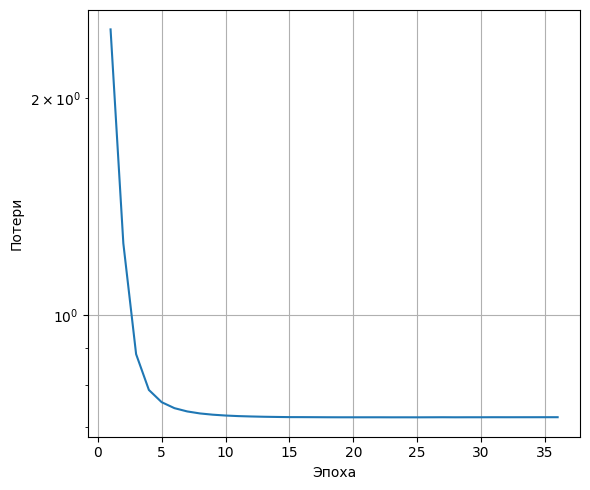

Loss treshhold reached. Epoch 36, loss: 0.7223, loss diff: -0.00000033
Размерность эмбеддингов: 64, узлов: 9485, форма X: (9485, 64)


In [53]:
# Эмбеддинги через PyTorch Geometric Node2Vec (без пакета node2vec)
import torch
try:
    from torch_geometric.nn import Node2Vec
except ImportError:
    from torch_geometric.nn.models import Node2Vec

from IPython.display import clear_output
import matplotlib.pyplot as plt

x_arr = []
y_arr = []

# Граф без хабов, неориентированный для блужданий
G_for_embed = G_no_hubs.to_undirected() if G_no_hubs.number_of_edges() > 0 else G_no_hubs
node_list = list(G_for_embed.nodes())
node_to_idx = {u: i for i, u in enumerate(node_list)}
n_nodes = len(node_list)

# Рёбра в формате PyG: edge_index (2, num_edges), индексы 0..n_nodes-1
edge_list = [(node_to_idx[u], node_to_idx[v]) for u, v in G_for_embed.edges()]
# Изолированные узлы не участвуют в рёбрах — добавляем петли, чтобы они попали в эмбеддинги
isolated_idx = set(range(n_nodes)) - {i for e in edge_list for i in e}
for i in isolated_idx:
    edge_list.append((i, i))

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Параметры (аналогично классическому Node2Vec)
EMBED_DIM = 64
WALK_LENGTH = 40
WALKS_PER_NODE = 20
CONTEXT_SIZE = 10
P, Q = 1.0, 1.0
MAX_EPOCHS = 500
LOSS_TRESHOLD = 0.000001

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Node2Vec(
    edge_index,
    embedding_dim=EMBED_DIM,
    walk_length=WALK_LENGTH,
    context_size=CONTEXT_SIZE,
    walks_per_node=WALKS_PER_NODE,
    p=P,
    q=Q,
    num_negative_samples=1,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loader = model.loader(batch_size=128, shuffle=True, num_workers=0)

# Обучение
model.train()
_loss = -1
for epoch in range(1, MAX_EPOCHS + 1):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    x_arr.append(epoch)
    y_arr.append(total_loss / len(loader))
    plt.clf()  # очищаем текущую фигуру
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_yscale("log")
    ax.set_xlabel("Эпоха")
    ax.set_ylabel("Потери")
    ax.grid()
    ax.plot(x_arr, y_arr)
    clear_output(wait=True)  # очищаем предыдущий вывод ячейки
    plt.tight_layout()
    plt.show()
    if abs(total_loss - _loss) / len(loader) < LOSS_TRESHOLD:
        print(f"Loss treshhold reached. Epoch {epoch}, loss: {total_loss / len(loader):.4f}, loss diff: {(total_loss - _loss) / len(loader):.8f}")
        break
    if _loss == -1:
        _loss = total_loss
    print(f"Epoch {epoch}, loss: {total_loss / len(loader):.4f}, loss diff: {(total_loss - _loss) / len(loader):.8f}")
    _loss = total_loss


# Эмбеддинги для всех узлов (порядок = node_list)
with torch.no_grad():
    z = model(torch.arange(n_nodes, device=device)).cpu().numpy()

nodes_embed = node_list
X = z
print(f"Размерность эмбеддингов: {EMBED_DIM}, узлов: {len(nodes_embed)}, форма X: {X.shape}")

In [54]:
# X и nodes_embed уже получены в ячейке выше (PyG Node2Vec)
# nodes_embed = node_list, X = z; порядок совпадает с G_no_hubs
print(f"Узлов с эмбеддингами: {len(nodes_embed)}, форма X: {X.shape}")

Узлов с эмбеддингами: 9485, форма X: (9485, 64)


In [55]:
# Проекция в 2D: t-SNE (или заменить на UMAP при наличии umap-learn)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, max(5, len(nodes_embed)//4)), max_iter=1000)
X_2d = tsne.fit_transform(X)
print("2D-координаты получены (t-SNE).")

2D-координаты получены (t-SNE).


In [56]:
# Привязка узла к компоненте: топ-N, изолированные отдельно, остальные — "Остальные"
N_TOP_COMPONENTS = 9
COMP_ISOLATED = N_TOP_COMPONENTS
COMP_OTHER = N_TOP_COMPONENTS + 1
isolated_in_no_hubs = {u for u in G_no_hubs.nodes() if G_no_hubs.out_degree(u) + G_no_hubs.in_degree(u) == 0}

node_to_comp = {}
for idx, comp in enumerate(components_no_hubs_sorted[:N_TOP_COMPONENTS]):
    for u in comp:
        node_to_comp[u] = idx
for n in G_no_hubs.nodes():
    if n not in node_to_comp:
        node_to_comp[n] = COMP_ISOLATED if n in isolated_in_no_hubs else COMP_OTHER

labels = np.array([node_to_comp[n] for n in nodes_embed])
num_plot_classes = N_TOP_COMPONENTS + 2

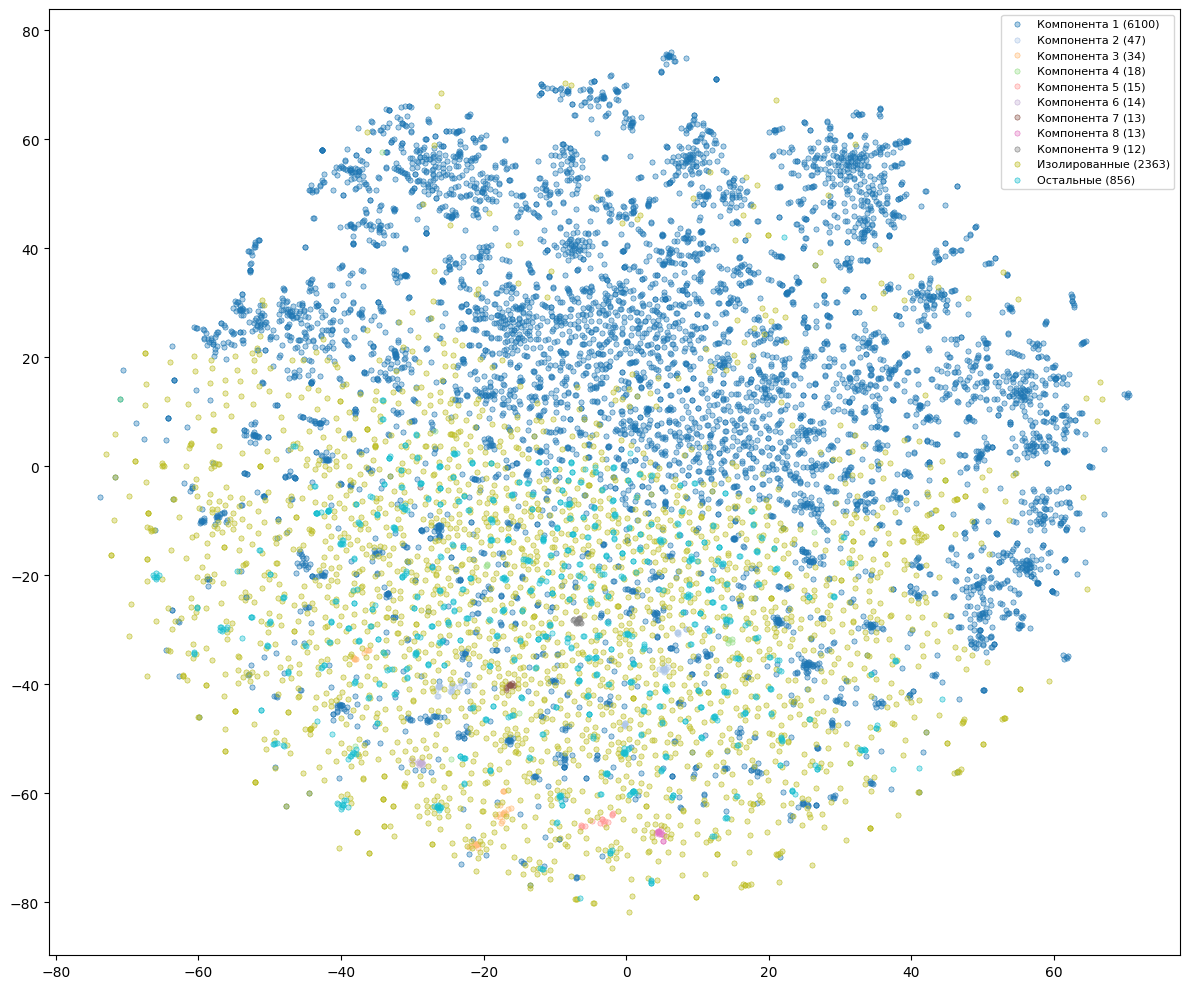

In [57]:
# Визуализация: контур + полупрозрачная заливка, легенда с размером компоненты
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
num_classes = num_plot_classes
# Палитра: для многих компонент — спектральная (уникальный цвет на класс)
if num_classes <= 20:
    base_colors = plt.cm.tab20(np.linspace(0, 1, num_classes, endpoint=False))
else:
    base_colors = plt.cm.hsv(np.linspace(0, 1, num_classes, endpoint=False))

comp_names = [f"Компонента {i+1}" for i in range(N_TOP_COMPONENTS)] + ["Изолированные"] + ["Остальные"]

for k in range(num_classes):
    mask = labels == k
    if not np.any(mask):
        continue
    size_k = int(np.sum(mask))
    edge_c = base_colors[k]
    face_c = base_colors[k].copy()
    face_c[3] = 0.35
    ax.scatter(
        X_2d[mask, 0], X_2d[mask, 1],
        c=[face_c], edgecolors=[edge_c], linewidths=0.4, s=14,
        label=f"{comp_names[k]} ({size_k})"
    )

# ax.set_title("Эмбеддинги статей (Node2Vec → t-SNE), по компонентам связности (граф без хабов)")
ax.legend(loc="best", fontsize=8)
# ax.set_xlabel("t-SNE 1")
# ax.set_ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

Для **3D-проекции** замените в ячейке выше `n_components=2` на `n_components=3`, постройте массив `X_3d` и используйте `ax.scatter(X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2], ...)` с `ax = fig.add_subplot(..., projection='3d')` (см. `mplot3d`).

## Дополнение: SPARQL из Python (GraphDB)

Если данные загружены в GraphDB, те же расчёты можно выполнять через SPARQL. Ниже — пример: топ статей по исходящей степени через эндпоинт. Задайте `GRAPHDB_ENDPOINT` или переменную `endpoint`.

In [58]:
# Пример SPARQL: топ-10 статей по исходящей степени (с названием)
SPARQL_TOP_OUT_DEGREE = """
PREFIX sg: <https://scilib.ai/ontology/semantic-graph/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?article ?label (COUNT(?o) AS ?outDegree) {
  ?article a sg:Article ;
          rdfs:label ?label ;
          ?p ?o .
  FILTER (?p IN (sg:hasAuthor, sg:hasTerm, sg:hasThesaurus, sg:refersTo, sg:hasFormula, sg:hasRelation))
} GROUP BY ?article ?label
ORDER BY DESC(?outDegree)
LIMIT 10
"""
# Выполнение (раскомментируйте и укажите endpoint):
# from graph_loader import run_sparql, get_sparql_endpoint
# rows = run_sparql(SPARQL_TOP_OUT_DEGREE, endpoint=get_sparql_endpoint())
# pd.DataFrame(rows)